instalação do orquestrador de agentes que é o langchain

In [1]:
!pip install -q --upgrade langchain langchain-google-genai google-generativeai

configuração das chaves que dão acesso aos modelos da IA do Google

In [2]:
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI

GOOGLE_API_KEY = userdata.get('GEMINI_API_KEY')

conexão com o google gemini

In [3]:
llm = ChatGoogleGenerativeAI(
    model = "gemini-2.5-flash",
    temperature=1,
    api_key=GOOGLE_API_KEY
)

In [4]:
# resposta_teste  = llm.invoke("Quem é você? Seja criativo")
# print(resposta_teste.content)

In [5]:
FEEDBACK_ROUTER_PROMPT = (
    "Você é um Analista de Produto, especialista em interpretar a voz do cliente."
    "Seu objetivo é analisar o feedback de um usuário e direcioná-lo para a equipe correta para ação."
    "Analise o feedback e retorne SOMENTE um JSON com sua análise:\n"
    "{\n"
    '  "pensamento": "...",\n'
    '  "acao_sugerida": "ENVIAR_PARA_PRODUTO" | "ENVIAR_PARA_SUPORTE" | "ENVIAR_PARA_MARKETING" | "PEDIR_INFO" | "ABRIR_CHAMADO",\n'
    '  "nivel_prioridade": "ALTA" | "MEDIA" | "BAIXA",\n'
    '  "dados_adicionais": {"tipo_feedback": "Sugestão de Feature | Relato de Bug | Elogio | Reclamação"}\n'
    '  "campos_faltantes": ["..."]\n'
    "}\n\n"
    "## Diretrizes de Decisão:\n"
    "- **ENVIAR_PARA_PRODUTO**: O feedback contém uma sugestão de nova funcionalidade ('seria legal se...'), ou uma crítica construtiva sobre o design/usabilidade.\n"
    "- **ENVIAR_PARA_SUPORTE**: O usuário está relatando um erro, um bug, ou algo que não está funcionando como esperado ('não consigo clicar no botão...'). Prioridade ALTA se impedir o uso.\n"
    "- **ENVIAR_PARA_MARKETING**: O usuário está fazendo um elogio sobre o produto, o que pode ser usado como um depoimento, ou está comparando o produto com concorrentes.\n"
    '- **PEDIR_INFO**: Mensagens vagas ou que faltam informações para identificar o tema ou contexto (Ex: "Preciso de ajuda com uma política", "Tenho uma dúvida geral").\n'
    '- **ABRIR_CHAMADO**: Pedidos de exceção, liberação, aprovação ou acesso especial, ou quando o usuário explicitamente pede para abrir um chamado (Ex: "Quero exceção para trabalhar 5 dias remoto.", "Solicito liberação para anexos externos.", "Por favor, abra um chamado para o RH.").'
    "Analise a mensagem e decida a ação mais apropriada."
)

Bibliotecas que ajudam o output a ser mais estruturado

In [6]:
from pydantic import BaseModel, Field
from typing import Literal, List, Dict

class FeedbackOut(BaseModel):
  acao_sugerida: Literal["ENVIAR_PARA_PRODUTO" , "ENVIAR_PARA_SUPORTE" , "ENVIAR_PARA_MARKETING", "PEDIR_INFO", "ABRIR_CHAMADO"]
  nivel_prioridade: Literal["ALTA" , "MEDIA" , "BAIXA"]
  dados_adicionais: List[str] = Field(default_factory=list)

In [7]:
llm_feedback = ChatGoogleGenerativeAI(
    model = "gemini-2.5-flash",
    temperature=0,
    api_key=GOOGLE_API_KEY
)

Bibliotecas do langchain pro modelo executar aquilo que a gente quer com a saída estruturada definida anteriormente

In [8]:
from langchain_core.messages import SystemMessage, HumanMessage

feedback_chain = llm_feedback.with_structured_output(FeedbackOut)

def feedback(mensagem: str) -> Dict:
  saida:FeedbackOut = feedback_chain.invoke([
      SystemMessage(content=FEEDBACK_ROUTER_PROMPT),
      HumanMessage(content=mensagem)
  ])
  return saida.model_dump()


In [9]:
testes_feedback = [
    "Não estou conseguindo fazer login no sistema",
    "Seria bom se o app tivesse um tema escuro",
    "O novo design do app ficou sensacional",
    "O céu é azul e quem é você ?"
]


In [10]:
for msg_teste in testes_feedback:
  print(f"Mensagem: {msg_teste}\n -> Resposta: {feedback(msg_teste)}\n")

Mensagem: Não estou conseguindo fazer login no sistema
 -> Resposta: {'acao_sugerida': 'ENVIAR_PARA_SUPORTE', 'nivel_prioridade': 'ALTA', 'dados_adicionais': ['Relato de Bug']}

Mensagem: Seria bom se o app tivesse um tema escuro
 -> Resposta: {'acao_sugerida': 'ENVIAR_PARA_PRODUTO', 'nivel_prioridade': 'MEDIA', 'dados_adicionais': ['Sugestão de Feature']}

Mensagem: O novo design do app ficou sensacional
 -> Resposta: {'acao_sugerida': 'ENVIAR_PARA_MARKETING', 'nivel_prioridade': 'BAIXA', 'dados_adicionais': ['{"tipo_feedback": "Elogio"}']}

Mensagem: O céu é azul e quem é você ?
 -> Resposta: {'acao_sugerida': 'PEDIR_INFO', 'nivel_prioridade': 'BAIXA', 'dados_adicionais': []}



Conexões com a leitura de documentos em pdf

In [11]:
!pip install -q --upgrade langchain_community faiss-cpu langchain-text-splitters pymupdf

Salvar os pdfs numa lista

In [12]:
from pathlib import Path
from langchain_community.document_loaders import PyMuPDFLoader

docs = []

for n in Path("/content/").glob("*.pdf"):
    try:
        loader = PyMuPDFLoader(str(n))
        docs.extend(loader.load())
        print(f"Carregado com sucesso arquivo {n.name}")
    except Exception as e:
        print(f"Erro ao carregar arquivo {n.name}: {e}")

print(f"Total de documentos carregados: {len(docs)}")

Carregado com sucesso arquivo manual_usuario_feedback_app_v1.2.pdf
Carregado com sucesso arquivo politica_interna_de_feedback_v2.pdf
Carregado com sucesso arquivo roadmap_produto_q4_2025.pdf
Total de documentos carregados: 6


In [13]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)

chunks = splitter.split_documents(docs)

In [14]:
for chunk in chunks:
    print(chunk)
    print("------------------------------------")

page_content='Manual do Usuário – FeedbackApp v1.2 
Última atualização: 12 de setembro de 2025 
1. Bem-vindo ao FeedbackApp! 
Bem-vindo à documentação oficial do FeedbackApp, sua plataforma central para coletar, 
analisar e agir sobre o feedback de seus clientes. Este manual detalha todas as 
funcionalidades disponíveis na versão 1.2. 
2. Primeiros Passos 
2.1. Criando sua Conta e Fazendo Login 
O acesso à plataforma é realizado através de um e-mail e senha cadastrados. Atualmente, não 
oferecemos suporte para login via redes sociais (Google, Microsoft). Caso tenha esquecido sua 
senha, utilize o link "Esqueci minha senha" disponível na página de login para iniciar o processo 
de recuperação. 
2.2. Conhecendo o Dashboard Principal 
Ao fazer login, você será apresentado ao Dashboard de Análise. Ele oferece uma visão geral e 
em tempo real da satisfação do seu cliente, com os seguintes componentes: 
●​ Volume de Feedbacks: Gráfico mostrando o número de feedbacks recebidos nos 
últimos 30

In [15]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001",
    google_api_key=GOOGLE_API_KEY
)

In [16]:
from langchain_community.vectorstores import FAISS

vectorstore = FAISS.from_documents(chunks, embeddings)

retriever = vectorstore.as_retriever(search_type="similarity_score_threshold",
                                     search_kwargs={"score_threshold":0.3, "k": 4})

In [17]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain

prompt_rag = ChatPromptTemplate.from_messages([
    ("system",
     "Você é um Assistente de um produto que funciona como uma plataforma central para coletar, analisar e agir sobre o feedback de seus clientes. "
     "Responda SOMENTE com base no contexto fornecido. "
     "Se não houver base suficiente, responda apenas 'Não sei'."),

    ("human", "Pergunta: {input}\n\nContexto:\n{context}")
])

document_chain = create_stuff_documents_chain(llm_feedback, prompt_rag)

In [18]:
# Formatadores
import re, pathlib

def _clean_text(s: str) -> str:
    return re.sub(r"\s+", " ", s or "").strip()

def extrair_trecho(texto: str, query: str, janela: int = 240) -> str:
    txt = _clean_text(texto)
    termos = [t.lower() for t in re.findall(r"\w+", query or "") if len(t) >= 4]
    pos = -1
    for t in termos:
        pos = txt.lower().find(t)
        if pos != -1: break
    if pos == -1: pos = 0
    ini, fim = max(0, pos - janela//2), min(len(txt), pos + janela//2)
    return txt[ini:fim]

def formatar_citacoes(docs_rel: List, query: str) -> List[Dict]:
    cites, seen = [], set()
    for d in docs_rel:
        src = pathlib.Path(d.metadata.get("source","")).name
        page = int(d.metadata.get("page", 0)) + 1
        key = (src, page)
        if key in seen:
            continue
        seen.add(key)
        cites.append({"documento": src, "pagina": page, "trecho": extrair_trecho(d.page_content, query)})
    return cites[:3]

In [19]:
def perguntar_politica_RAG(pergunta: str) -> Dict:
    docs_relacionados = retriever.invoke(pergunta)

    if not docs_relacionados:
        return {"answer": "Não sei.",
                "citacoes": [],
                "contexto_encontrado": False}

    answer = document_chain.invoke({"input": pergunta,
                                    "context": docs_relacionados})

    txt = (answer or "").strip()

    if txt.rstrip(".!?") == "Não sei":
        return {"answer": "Não sei.",
                "citacoes": [],
                "contexto_encontrado": False}

    return {"answer": txt,
            "citacoes": formatar_citacoes(docs_relacionados, pergunta),
            "contexto_encontrado": True}

In [20]:
testes = ["Como acessar o aplicativo ?",
          "Quero relatar um problema que enfrentei usando o produto. Como faço?",
          "Quem eu posso contatar pra tirar uma dúvida?",
          "Se o céu é azul, quem é você?"]

In [21]:
for msg_teste in testes:
    resposta = perguntar_politica_RAG(msg_teste)
    print(f"PERGUNTA: {msg_teste}")
    print(f"RESPOSTA: {resposta['answer']}")
    if resposta['contexto_encontrado']:
        print("CITAÇÕES:")
        for c in resposta['citacoes']:
            print(f" - Documento: {c['documento']}, Página: {c['pagina']}")
            print(f"   Trecho: {c['trecho']}")
        print("------------------------------------")

PERGUNTA: Como acessar o aplicativo ?
RESPOSTA: O acesso à plataforma é realizado através de um e-mail e senha cadastrados.
CITAÇÕES:
 - Documento: manual_usuario_feedback_app_v1.2.pdf, Página: 1
   Trecho: Manual do Usuário – FeedbackApp v1.2 Última atualização: 12 de setembro de 2025 1. Bem-vindo ao FeedbackApp! Bem-vindo à
 - Documento: manual_usuario_feedback_app_v1.2.pdf, Página: 2
   Trecho: stir, verifique sua conexão com a internet. Este problema às vezes ocorre em versões desatualizadas do navegador. ●​ P: Como posso sugerir uma nova funcionalidade?
 - Documento: roadmap_produto_q4_2025.pdf, Página: 2
   Trecho: ão Priorizado no Momento Funcionalidades que foram sugeridas mas que não estão alinhadas com nossa estratégia atual. ●​ Aplicativo Mobile Nativo (iOS/Android): No momento, nosso foco é aprimorar a experiência na web, que já é totalmente res
------------------------------------
PERGUNTA: Quero relatar um problema que enfrentei usando o produto. Como faço?
RESPOSTA: Para

In [22]:
!pip install -q --upgrade langgraph

In [23]:
from typing import TypedDict, Optional

class AgentState(TypedDict, total = False):
    pergunta: str
    feedback: dict
    resposta: Optional[str]
    citacoes: List[dict]
    rag_sucesso: bool
    acao_final: str

In [24]:
def node_feedback(state: AgentState) -> AgentState:
    print("Executando nó de feedback...")
    return {"feedback": feedback(state["pergunta"])}

In [25]:
def node_auto_resolver_produto(state: AgentState) -> AgentState:
    print("Executando nó de enviar_para_produto...")
    resposta_rag = perguntar_politica_RAG(state["pergunta"])

    update: AgentState = {
        "resposta": resposta_rag["answer"],
        "citacoes": resposta_rag.get("citacoes", []),
        "rag_sucesso": resposta_rag["contexto_encontrado"],
    }

    if resposta_rag["contexto_encontrado"]:
        update["acao_final"] = "ENVIAR_PARA_PRODUTO"

    return update

In [26]:
def node_auto_resolver_marketing(state: AgentState) -> AgentState:
    print("Executando nó de enviar_para_marketing...")
    resposta_rag = perguntar_politica_RAG(state["pergunta"])

    update: AgentState = {
        "resposta": resposta_rag["answer"],
        "citacoes": resposta_rag.get("citacoes", []),
        "rag_sucesso": resposta_rag["contexto_encontrado"],
    }

    if resposta_rag["contexto_encontrado"]:
        update["acao_final"] = "ENVIAR_PARA_MARKETING"

    return update

In [27]:
def node_auto_resolver_suporte(state: AgentState) -> AgentState:
    print("Executando nó de enviar_para_suporte...")
    resposta_rag = perguntar_politica_RAG(state["pergunta"])

    update: AgentState = {
        "resposta": resposta_rag["answer"],
        "citacoes": resposta_rag.get("citacoes", []),
        "rag_sucesso": resposta_rag["contexto_encontrado"],
    }

    if resposta_rag["contexto_encontrado"]:
        update["acao_final"] = "ENVIAR_PARA_SUPORTE"

    return update

In [28]:
def node_pedir_info(state: AgentState) -> AgentState:
    print("Executando nó de pedir_info...")
    faltantes = state["feedback"].get("campos_faltantes", [])
    if faltantes:
        detalhe = ",".join(faltantes)
    else:
        detalhe = "Tema e contexto específico"

    return {
        "resposta": f"Para avançar, preciso que detalhe: {detalhe}",
        "citacoes": [],
        "acao_final": "PEDIR_INFO"
    }

In [29]:
#pensar em como conectar com um email para direcionar esse chamado
def node_abrir_chamado(state: AgentState) -> AgentState:
    print("Executando nó de abrir_chamado...")
    feedback = state["feedback"]

    return {
        "resposta": f"Abrindo chamado com urgência {feedback['nivel_prioridade']}. Descrição: {state['pergunta'][:140]}",
        "citacoes": [],
        "acao_final": "ABRIR_CHAMADO"
    }

In [30]:
KEYWORDS_ABRIR_TICKET = ["aprovação", "exceção", "liberação", "abrir ticket", "abrir chamado", "acesso especial"]

def decidir_pos_triagem(state: AgentState) -> str:
    print("Decidindo após a triagem...")
    decisao = state["feedback"]["acao_sugerida"]

    if decisao == "ENVIAR_PARA_PRODUTO": return node_auto_resolver_produto
    if decisao == "ENVIAR_PARA_SUPORTE": return node_auto_resolver_suporte
    if decisao == "ENVIAR_PARA_MARKETING": return node_auto_resolver_marketing
    if decisao == "PEDIR_INFO": return node_pedir_info
    if decisao == "ABRIR_CHAMADO": return node_abrir_chamado



In [31]:
def decidir_pos_auto_resolver(state: AgentState) -> str:
    print("Decidindo após o auto_resolver...")

    if state.get("rag_sucesso"):
        print("Rag com sucesso, finalizando o fluxo.")
        return "ok"

    state_da_pergunta = (state["pergunta"] or "").lower()

    if any(k in state_da_pergunta for k in KEYWORDS_ABRIR_TICKET):
        print("Rag falhou, mas foram encontradas keywords de abertura de ticket. Abrindo...")
        return "chamado"

    print("Rag falhou, sem keywords, vou pedir mais informações...")
    return "info"

In [32]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(AgentState)

workflow.add_node("feedback", node_feedback)
workflow.add_node("auto_resolver_produto", node_auto_resolver_produto)
workflow.add_node("auto_resolver_suporte", node_auto_resolver_suporte)
workflow.add_node("auto_resolver_marketing", node_auto_resolver_marketing)
workflow.add_node("pedir_info", node_pedir_info)
workflow.add_node("abrir_chamado", node_abrir_chamado)

workflow.add_edge(START, "feedback")

workflow.add_conditional_edges("feedback", decidir_pos_triagem, {
    node_auto_resolver_produto: "auto_resolver_produto",
    node_auto_resolver_suporte: "auto_resolver_suporte",
    node_auto_resolver_marketing: "auto_resolver_marketing",
    node_pedir_info: "pedir_info",
    node_abrir_chamado: "abrir_chamado"
})


workflow.add_conditional_edges("auto_resolver_produto", decidir_pos_auto_resolver, {
    "info": "pedir_info",
    "chamado": "abrir_chamado",
    "ok": END
})

workflow.add_conditional_edges("auto_resolver_suporte", decidir_pos_auto_resolver, {
    "info": "pedir_info",
    "chamado": "abrir_chamado",
    "ok": END
})

workflow.add_conditional_edges("auto_resolver_marketing", decidir_pos_auto_resolver, {
    "info": "pedir_info",
    "chamado": "abrir_chamado",
    "ok": END
})


workflow.add_edge("pedir_info", END)
workflow.add_edge("abrir_chamado", END)

grafo = workflow.compile()

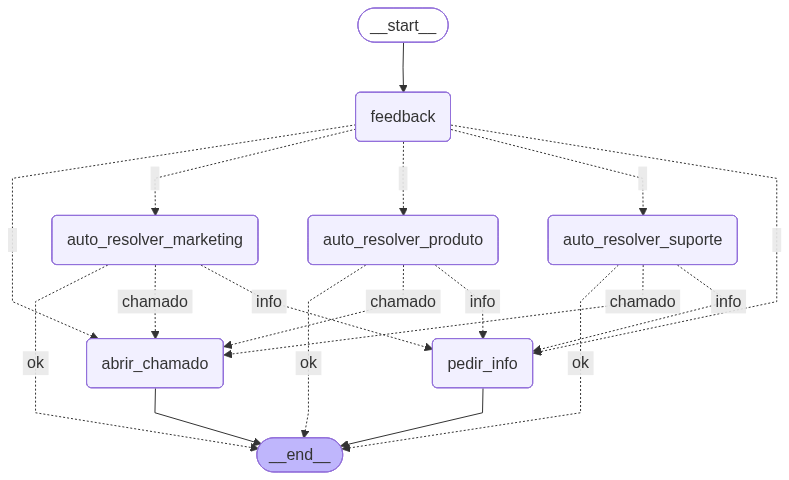

In [33]:
from IPython.display import display, Image

graph_bytes = grafo.get_graph().draw_mermaid_png()
display(Image(graph_bytes))

In [34]:
testes_feedback = [
    "Não estou conseguindo fazer login no sistema",
    "Seria bom se o app tivesse um tema escuro",
    "O novo design do app ficou sensacional",
    "O céu é azul e quem é você ?",
    "Posso obter o Google Gemini de graça ?"
]

In [36]:
for msg_test in testes_feedback:
    resposta_final = grafo.invoke({"pergunta": msg_test})

    triag = resposta_final.get("feedback", {})
    print(f"PERGUNTA: {msg_test}")
    print(f"DECISÃO: {triag.get('decisao')} | URGÊNCIA: {triag.get('nivel_prioridade')} | AÇÃO FINAL: {resposta_final.get('acao_final')}")
    print(f"RESPOSTA: {resposta_final.get('resposta')}")
    if resposta_final.get("citacoes"):
        print("CITAÇÕES:")
        for citacao in resposta_final.get("citacoes"):
            print(f" - Documento: {citacao['documento']}, Página: {citacao['pagina']}")
            print(f"   Trecho: {citacao['trecho']}")

    print("------------------------------------")

Executando nó de feedback...
Decidindo após a triagem...
Executando nó de enviar_para_suporte...
Decidindo após o auto_resolver...
Rag com sucesso, finalizando o fluxo.
PERGUNTA: Não estou conseguindo fazer login no sistema
DECISÃO: None | URGÊNCIA: ALTA | AÇÃO FINAL: ENVIAR_PARA_SUPORTE
RESPOSTA: Para problemas de login, o manual sugere as seguintes ações:

*   Se o botão 'Entrar' não estiver funcionando, tente limpar o cache do seu navegador e recarregar a página.
*   Se o problema persistir, verifique sua conexão com a internet.
*   Este problema às vezes ocorre em versões desatualizadas do navegador.
*   Caso tenha esquecido sua senha, utilize o link "Esqueci minha senha" disponível na página de login para iniciar o processo de recuperação.
CITAÇÕES:
 - Documento: manual_usuario_feedback_app_v1.2.pdf, Página: 1
   Trecho: a senha" disponível na página de login para iniciar o processo de recuperação. 2.2. Conhecendo o Dashboard Principal Ao fazer login, você será apresentado ao Dash